The data has the following two tables:
1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:
    
● name: the user's name
    
● object_id: the user's id
    
● email: email address
    
● creation_source: how their account was created. This takes on one of 5 values:
        
○ PERSONAL_PROJECTS: invited to join another user's personal workspace
    
○ GUEST_INVITE: invited to an organization as a guest(limited permissions)
    
○ ORG_INVITE: invited to an organization (as a full member)
    
○ SIGNUP: signed up via the website
    
○ SIGNUP_GOOGLE_AUTH: signed up using Google
    
Authentication (using a Google email account for their login id)

● creation_time: when they created their account
    
● last_session_creation_time: unix timestamp of last login
    
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    
● enabled_for_marketing_drip: whether they are on the regular marketing email drip
    
● org_id: the organization (group of users) they belong to
    
● invited_by_user_id: which user invited them to join (if applicable).
    
2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption .

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.

Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [254]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import timedelta
from datetime import date

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [195]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [223]:
users = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1")

In [197]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [198]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [199]:
user_engagement['user_id'].nunique()

8823

There are 207917 logins and 8823 users 

In [200]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

In [201]:
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [202]:
# run the function on all users
adopted = user_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [203]:
adopted

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted_user, Length: 8823, dtype: bool

In [204]:
print('There were {} adopted users out of {} users'.format(sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [205]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [224]:
users = users.drop(['name','email'],axis =1)

In [225]:
users['last_session_creation_time']= pd.to_datetime(users['last_session_creation_time'], unit='s')

In [226]:
users['creation_time']= pd.to_datetime(users['creation_time'],format='%Y-%m-%d %H:%M:%S')

In [227]:
users['acount_history']=  users['last_session_creation_time'] - users['creation_time']

In [228]:
users['acount_history'] = users['acount_history'].dt.days

In [230]:
users['age_account'] = max(users['creation_time']) - users['creation_time']


In [231]:
users['age_account'] = users['age_account'].dt.days

In [232]:
users = users.drop(['last_session_creation_time','creation_time'],axis =1)

In [233]:
users.rename(columns={'object_id': 'user_id'},inplace=True)


In [234]:
users = pd.merge(users,adopted,how='inner',on='user_id')

In [235]:
users.isna().sum()

user_id                          0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
acount_history                   0
age_account                      0
adopted_user                     0
dtype: int64

In [236]:
users.head()

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,acount_history,age_account,adopted_user
0,1,GUEST_INVITE,1,0,11,10803.0,0.0,38,False
1,2,ORG_INVITE,0,0,1,316.0,136.0,196,True
2,3,ORG_INVITE,0,0,94,1525.0,0.0,437,False
3,4,GUEST_INVITE,0,0,1,5151.0,1.0,374,False
4,5,GUEST_INVITE,0,0,193,5240.0,5.0,498,False


## EDA

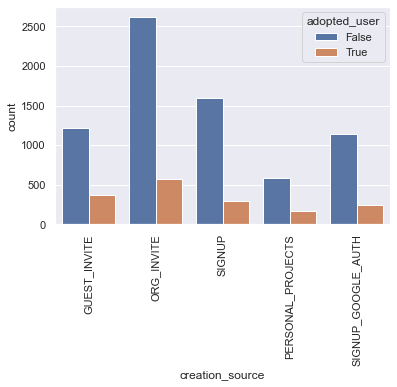

In [237]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=users, hue='adopted_user')
_ = plt.xticks(rotation=90)

The number of adopteds user are same between differnt sources, but the number of people who are not active (adopted=False) is much higher in ORG_INVITE

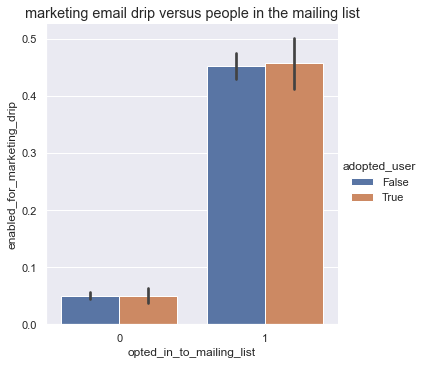

In [241]:
_ = sns.set()
_ = sns.catplot(x="opted_in_to_mailing_list", y="enabled_for_marketing_drip", hue='adopted_user', kind='bar', data=users)
_ = plt.title("marketing email drip versus people in the mailing list", size='large')



This graph make sense as people who have opted into receiving marketing emails, they are more on the regular marketing email drip

### Preparing the data for modeling

In [245]:
# finding the type and NAN value in the data 
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     8823 non-null   int64  
 1   creation_source             8823 non-null   object 
 2   opted_in_to_mailing_list    8823 non-null   int64  
 3   enabled_for_marketing_drip  8823 non-null   int64  
 4   org_id                      8823 non-null   int64  
 5   invited_by_user_id          4776 non-null   float64
 6   acount_history              8823 non-null   float64
 7   age_account                 8823 non-null   int64  
 8   adopted_user                8823 non-null   bool   
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 629.0+ KB


Since there are (8823 - 4776) missed value for invited_by_user_id( almost half of the data were missed), I excluded this columns 

In [246]:
users = users.drop(['invited_by_user_id'], axis =1)

In [335]:
# get dummies ffor creation source feature
creation_source = pd.get_dummies(users['creation_source'], drop_first=True)
users_ML = pd.concat([creation_source,users],axis=1).drop('creation_source',axis=1)

In [336]:
users_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ORG_INVITE                  8823 non-null   uint8  
 1   PERSONAL_PROJECTS           8823 non-null   uint8  
 2   SIGNUP                      8823 non-null   uint8  
 3   SIGNUP_GOOGLE_AUTH          8823 non-null   uint8  
 4   user_id                     8823 non-null   int64  
 5   opted_in_to_mailing_list    8823 non-null   int64  
 6   enabled_for_marketing_drip  8823 non-null   int64  
 7   org_id                      8823 non-null   int64  
 8   acount_history              8823 non-null   float64
 9   age_account                 8823 non-null   int64  
 10  adopted_user                8823 non-null   bool   
dtypes: bool(1), float64(1), int64(5), uint8(4)
memory usage: 525.6 KB


In [337]:
users_ML.columns

Index(['ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH',
       'user_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'acount_history', 'age_account', 'adopted_user'],
      dtype='object')

In [338]:
scaler = MinMaxScaler()
users_scaled = users_ML[['acount_history','age_account']]
users_scaled = scaler.fit_transform(users_scaled.to_numpy())
users_scaled = pd.DataFrame(users_scaled, columns=['acount_history', 'age_account'])
 
users_scaled.head()

,acount_history,age_account
0,0.000000,0.052126
1,0.186557,0.268861
2,0.000000,0.599451
3,0.001372,0.513032
4,0.006859,0.683128


In [339]:
users_ML = users_ML.drop(['acount_history','age_account'], axis=1)

In [340]:
users_ML = pd.concat([users_ML,users_scaled[['acount_history','age_account']]],axis=1)

In [341]:
users_ML.head()

,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,acount_history,age_account
0,0,0,0,0,1,1,0,11,False,0.000000,0.052126
1,1,0,0,0,2,0,0,1,True,0.186557,0.268861
2,1,0,0,0,3,0,0,94,False,0.000000,0.599451
3,0,0,0,0,4,0,0,1,False,0.001372,0.513032
4,0,0,0,0,5,0,0,193,False,0.006859,0.683128


### Predictive modeling 

In [342]:
# divide the data into label and features for use in ml models
y = users_ML['adopted_user']
X = users_ML.drop(columns =['adopted_user','user_id','org_id'])

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Random forest Classifer 


In [343]:
RF= RandomForestClassifier(max_depth=3, random_state=0)
RF.fit(X_train, y_train)
y_predict = RF.predict(X_test)

In [344]:
print('Accuracy on training set = {}'.format(RF.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(RF.score(X_test, y_test)))

Accuracy on training set = 0.9648639896373057
Accuracy on test set = 0.9625991688704193


In [345]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98      2136
        True       0.96      0.84      0.90       511

    accuracy                           0.96      2647
   macro avg       0.96      0.92      0.94      2647
weighted avg       0.96      0.96      0.96      2647



In [346]:
#Hypertuning Random Forest 
param_grid = {
    'max_depth': [3, 10, 20],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 250, 500,]
}
# Create a based model
RF = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, cv = 3, scoring='accuracy' )

In [347]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 250}

In [348]:
y_pred = grid_search.predict(X_test)
print(grid_search.score(X_test, y_test))

0.9622213826973933


In [349]:
grid_search.best_score_

0.9659980368566862

In [350]:
grid_search.best_params_ 

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 250}

In [351]:
#final model with parameters found through gridsearch
RF = RandomForestClassifier(n_estimators= 100, max_depth= 10, min_samples_split=5, min_samples_leaf=1,random_state=0)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print('Accuracy on training set = {}'.format(RF.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(RF.score(X_test, y_test)))

Accuracy on training set = 0.9784650259067358
Accuracy on test set = 0.9603324518322629


In [352]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.98      2136
        True       0.92      0.87      0.89       511

    accuracy                           0.96      2647
   macro avg       0.95      0.93      0.93      2647
weighted avg       0.96      0.96      0.96      2647



In [353]:
#  The importance of features 
ultimate_features = pd.DataFrame({'importance': RF.feature_importances_}, index=X.columns[:])
ultimate_features.sort_values('importance', ascending=False)

,importance
acount_history,0.926300
age_account,0.060319
opted_in_to_mailing_list,0.002674
enabled_for_marketing_drip,0.002429
SIGNUP,0.002254
ORG_INVITE,0.002212
SIGNUP_GOOGLE_AUTH,0.002125
PERSONAL_PROJECTS,0.001687


Random forest has very good results in prediction of adopted users (precision of 92% and recall of 87%).
The most important features for predicting the adopted users are age account, account hisotry, whether they have opted into receiving marketing emails, and accept to recieve the marketing email.I recomend to encourgae people who already have account to login more in the software as it has the highest effect on adopting the user (92%) . We can not do anything about the time the user created their account(age account).Also it will be effective to conviece people to be opted to recieve the marketing email and be in the regular marketing list. Among different sources for creating their account, the SIGNUP and inivtation by organization have more effect on the adopted user.   Thefore it will be effective to advertise their softwar through organization or on media and people become motivated to create their account. 